# 0712: I think there are something wrong with the code of comb noise, but it's just the same as the matlab code.  use yita=0.6 as im/comb=0.2,yita=0.7 as all comb noise-----------0717-------------yita=im/comb, so it should be yita=0.6 as all comb noise,yita = 0.7 as im/comb=0.2-----------0717modified the comb_noise function,and try real value-------0720the comb noise is correct now, but the BER is still very low, simulate the BER performance

E:\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


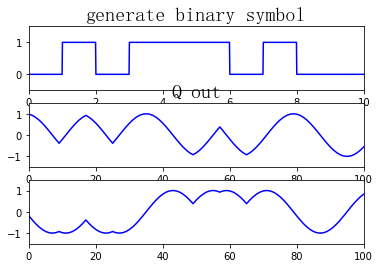

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from math import pi
from scipy import interpolate 
import matplotlib.pyplot as plt
import matplotlib
import scipy.signal as signal
import math
from scipy.stats import levy_stable
import CommFunc as CF
from keras.utils import np_utils

#----------import my function-----------
import noise
import comb_noise as cmbn

# get the train and test data
# generate symbol

data_len=1000
sample_num=8
Rb=100
fc=20000
sampling_t=0.01
t=np.arange(0,data_len,sampling_t)
multi=int(fc/Rb)
def symbol_out(data_len):
  a = np.random.randint(0, 2, data_len)
  m = np.zeros(len(t), dtype=np.float32)
  for i in range(len(t)):
    m[i] = a[math.floor(t[i])]
  for i in range(len(a)):
    if a[i]>0:
      a[i]=a[i]
    else:
      a[i]=-1
  return a,m
data,data_p=symbol_out(data_len)
# 解决set_title中文乱码
 
zhfont1 = matplotlib.font_manager.FontProperties(fname = 'C:\Windows\Fonts\simsun.ttc')
#------plot figure----------
fig = plt.figure() 
ax1 = fig.add_subplot(3, 1, 1)
ax1.set_title('generate binary symbol', fontproperties = zhfont1, fontsize = 20)
 
plt.axis([0, 10, -0.5, 1.5])
 
plt.plot(t, data_p, 'b')

#---------- I and Q---------
def IQ_msk(data,data_len,sample_num,Rb):
    Tb=1/Rb
    #fs=Rb*sample_num
    # sampling
    data_sample=np.zeros(data_len*sample_num)
    count=0
    for i in range(data_len):
      data_sample[count:(i+1)*sample_num+1]=data[i]
      count=(i+1)*sample_num+1
    # phase
    phase=np.zeros(data_len*sample_num)
    phase[0]=data_sample[0]*pi/2/sample_num
    for i in range(1,data_len*sample_num):
      phase[i]=phase[i-1]+data_sample[i-1]*pi/2/sample_num
    I_out=np.cos(phase)
    Q_out=np.sin(phase)
    return I_out,Q_out
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
#-------plot figure--------------
ax2=fig.add_subplot(3,1,2)
ax2.set_title('I out', fontproperties = zhfont1, fontsize = 20)
plt.axis([0, 100, -1.5, 1.5])
plt.plot(I_out, 'b')
ax3=fig.add_subplot(3,1,3)
ax2.set_title('Q out', fontproperties = zhfont1, fontsize = 20)
plt.axis([0, 100, -1.5, 1.5])
plt.plot(Q_out, 'b')
plt.show()
#---modulate to defined frequency-----
def carriermod(fc,Rb,I_out,Q_out):
    pass
    multi = fc/Rb
    x_I=np.linspace(0,len(I_out)-1,len(I_out))
    x_Itemp=np.linspace(0,len(I_out)-1,(len(I_out)*multi))
    f_I = interpolate.interp1d(x_I,I_out,kind="slinear")
    I_temp=f_I(x_Itemp)
    x_Q=np.linspace(0,len(Q_out)-1,len(Q_out))
    x_Qtemp=np.linspace(0,len(Q_out)-1,(len(Q_out)*multi))
    f_Q = interpolate.interp1d(x_Q,Q_out,kind="slinear")
    Q_temp=f_Q(x_Qtemp)


    fs=fc*sample_num
    ts = np.arange(0, (len(I_temp)* 1) / fs, 1 / fs)
    signal_I=I_temp*np.cos(np.dot(2*pi*fc,ts))
    signal_Q=Q_temp*np.sin(np.dot(2*pi*fc,ts))

    signal_mod=signal_I-signal_Q
    return signal_mod
signal_mod=carriermod(fc,Rb,I_out,Q_out)

In [2]:
#--------------prepare the convolutional neural network-------------
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D,AveragePooling1D
from keras.layers.core import Dense, Lambda, GatedDense
from keras.utils import np_utils
print ('the library of the network has been prepared')
#-------------define the number of classes of the signal (means 0/1 )--------
num_classes = 2
#-----------construct the 1D CNN-----------------------
# 1D CNN neural network
#input_shape = 1600
model_m = Sequential()
model_m.add(Reshape((sample_num*5, 40), input_shape=(1600,)))
model_m.add(Conv1D(200, 4, activation='relu', input_shape=(sample_num,200)))
model_m.add(Conv1D(200, 4, activation='relu'))
#model_m.add(Reshape((200*34，))
model_m.add(GatedDense(128))
model_m.add(GatedDense(64))
#model_m.add(Dense(128))
#model_m.add(Dense(64))
#model_m.add(AveragePooling1D(2))
#model_m.add(Conv1D(160, 5, activation='relu'))
#model_m.add(Conv1D(160, 4, activation='relu'))
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


# In[66]:


#------------compile the CNN--------------
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
print('the model has been compiled')


the library of the network has been prepared
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 40, 40)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 37, 200)           32200     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 34, 200)           160200    
_________________________________________________________________
gated_dense_1 (GatedDense)   (None, 34, 128)           102912    
_________________________________________________________________
gated_dense_2 (GatedDense)   (None, 34, 64)            33024     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (N

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


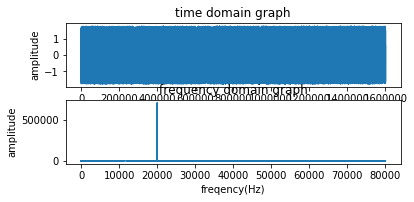

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [-0.33740423 -0.32480807 -1.21327264 ...  0.75295502  1.46911003
  0.57575649]
im_noise [0. 0. 0. ... 0. 0. 0.]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)


In [6]:
from pylab import *
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -2 # -6 #-4 #0 #6   #15
fs = fc*sample_num
def combnoise2(ebn0,length,fc,fs):
	N = length
	snr = 10**((ebn0)/10)
	Ptotal = 1/snr
	#length = 1000
	#P_im = Ptotal*yita
	P_comb = Ptotal*(1-yita)
	ts = np.arange(1/fs, (N+1) / fs, 1 / fs)
	#comb_noise = (P_comb**0.5)*np.random.randn(length)*np.cos(np.dot(2*pi*fc,ts))
	cosn = np.cos(np.dot(2*pi*fc,ts))
	sinn = np.sin(np.dot(2*pi*fc,ts))
	cmb_noise =  (P_comb**0.5)*np.random.random(length)*np.cos(np.dot(2*pi*fc,ts))- (P_comb**0.5)*np.random.random(length)*np.sin(np.dot(2*pi*fc,ts))
	return cmb_noise

cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)


Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 1s 1ms/step - loss: 0.6932 - acc: 0.4912 - val_loss: 0.6927 - val_acc: 0.4750
Epoch 2/200
800/800 [==============================] - 0s 543us/step - loss: 0.6934 - acc: 0.5012 - val_loss: 0.6933 - val_acc: 0.4750
Epoch 3/200
800/800 [==============================] - 0s 534us/step - loss: 0.6921 - acc: 0.5025 - val_loss: 0.6927 - val_acc: 0.4750
Epoch 4/200
800/800 [==============================] - 0s 542us/step - loss: 0.6897 - acc: 0.5225 - val_loss: 0.6889 - val_acc: 0.4500
Epoch 5/200
800/800 [==============================] - 0s 537us/step - loss: 0.6862 - acc: 0.5737 - val_loss: 0.6857 - val_acc: 0.6200
Epoch 6/200
800/800 [==============================] - 0s 542us/step - loss: 0.6839 - acc: 0.5850 - val_loss: 0.6812 - val_acc: 0.4800
Epoch 7/200
800/800 [==============================] - 0s 542us/step - loss: 0.6741 - acc: 0.5825 - val_loss: 0.6730 - val_acc: 0.6100
Epoch 8/200

Epoch 60/200
800/800 [==============================] - 0s 535us/step - loss: 3.9287e-04 - acc: 1.0000 - val_loss: 3.7054e-04 - val_acc: 1.0000
Epoch 61/200
800/800 [==============================] - 0s 545us/step - loss: 4.3669e-04 - acc: 1.0000 - val_loss: 3.6657e-04 - val_acc: 1.0000
Epoch 62/200
800/800 [==============================] - 0s 534us/step - loss: 3.8203e-04 - acc: 1.0000 - val_loss: 3.6189e-04 - val_acc: 1.0000
Epoch 63/200
800/800 [==============================] - 0s 541us/step - loss: 3.8082e-04 - acc: 1.0000 - val_loss: 3.5589e-04 - val_acc: 1.0000
Epoch 64/200
800/800 [==============================] - 0s 547us/step - loss: 4.1787e-04 - acc: 1.0000 - val_loss: 3.5152e-04 - val_acc: 1.0000
Epoch 65/200
800/800 [==============================] - 0s 541us/step - loss: 3.9372e-04 - acc: 1.0000 - val_loss: 3.4199e-04 - val_acc: 1.0000
Epoch 66/200
800/800 [==============================] - 0s 541us/step - loss: 3.6950e-04 - acc: 1.0000 - val_loss: 3.3675e-04 - val_acc:

Epoch 117/200
800/800 [==============================] - 0s 545us/step - loss: 2.1246e-04 - acc: 1.0000 - val_loss: 2.0978e-04 - val_acc: 1.0000
Epoch 118/200
800/800 [==============================] - 0s 550us/step - loss: 2.1165e-04 - acc: 1.0000 - val_loss: 2.0759e-04 - val_acc: 1.0000
Epoch 119/200
800/800 [==============================] - 0s 559us/step - loss: 2.3037e-04 - acc: 1.0000 - val_loss: 2.0589e-04 - val_acc: 1.0000
Epoch 120/200
800/800 [==============================] - 0s 554us/step - loss: 1.8959e-04 - acc: 1.0000 - val_loss: 2.0457e-04 - val_acc: 1.0000
Epoch 121/200
800/800 [==============================] - 0s 590us/step - loss: 2.1741e-04 - acc: 1.0000 - val_loss: 2.0290e-04 - val_acc: 1.0000
Epoch 122/200
800/800 [==============================] - 0s 551us/step - loss: 2.5650e-04 - acc: 1.0000 - val_loss: 2.0127e-04 - val_acc: 1.0000
Epoch 123/200
800/800 [==============================] - 0s 536us/step - loss: 1.7256e-04 - acc: 1.0000 - val_loss: 1.9993e-04 - v

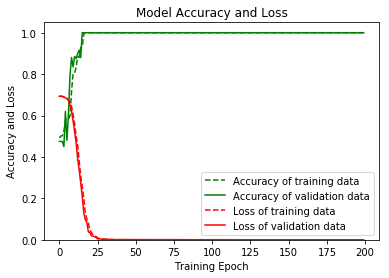

In [4]:
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr2dB_comb0.h5')

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1

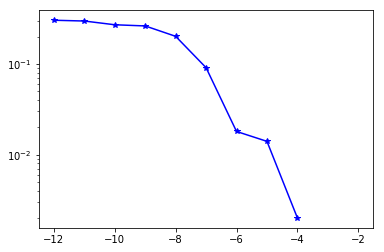

save txt have done


In [7]:
#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)
#*************alpha=1.5*******************************************
model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-2dBv20_te_12_2_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

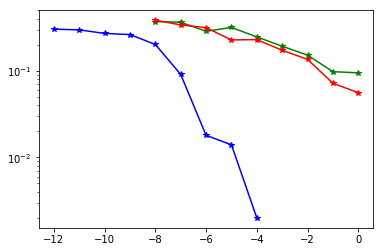

In [10]:
BER_cv = np.loadtxt('MSK_BER_80comb.txt')
BER_cv2 = np.loadtxt('MSK_BER_80comb02.txt')
ebn0 = [-8,-7,-6,-5,-4,-3,-2,-1,0]
EbN0 = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2]
BER = np.loadtxt('BER_MSK_GCNN_tr-2dBv20_te_12_2_comb.txt') 
plt.semilogy(EbN0,BER,'b*-')
plt.semilogy(ebn0,BER_cv,'g*-')
plt.semilogy(ebn0,BER_cv2,'r*-')
plt.show()

# yita=0 train -6dB -10dB

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # Remove the CWD from sys.path while we load stuff.


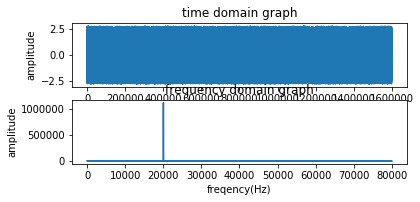

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [-0.13032945 -0.05924496 -1.52748385 ...  0.51279632  0.58968373
  0.73892649]
im_noise [0. 0. 0. ... 0. 0. 0.]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 537us/step - loss: 1.4006 - acc: 0.8113 - val_loss: 6.0226 - val_acc: 0.5250
Epoch 2/200
800/800 [==============================] - 0s 526us/step - loss: 5.9676 - acc: 0.5012 - val_loss: 4.4033 - val_acc: 0.5250
Epoch 3/200
800/800 [==============================] - 0s 547us/step - loss: 4.1778 - acc: 0.5012 - val_loss: 2.6624 - val_acc: 0.5250
Epoch 4/200
800/800 [==============================] - 0s 537us/step - loss: 2.5008 - acc: 0.5012 - val_loss: 1.3837 - val_acc: 0.5250
Epoch 5/200
800/800 [==============================] - 0s 537us/step - loss: 1.2654 - acc: 0.5012 - val_loss: 0.7555 - val_acc: 0.5250
Epoch 6/200


800/800 [==============================] - 0s 544us/step - loss: 0.6925 - acc: 0.5150 - val_loss: 0.6933 - val_acc: 0.4750
Epoch 60/200
800/800 [==============================] - 0s 545us/step - loss: 0.6946 - acc: 0.4725 - val_loss: 0.6933 - val_acc: 0.4750
Epoch 61/200
800/800 [==============================] - 0s 544us/step - loss: 0.6935 - acc: 0.4938 - val_loss: 0.6932 - val_acc: 0.4750
Epoch 62/200
800/800 [==============================] - 0s 521us/step - loss: 0.6941 - acc: 0.4787 - val_loss: 0.6932 - val_acc: 0.4750
Epoch 63/200
800/800 [==============================] - 0s 534us/step - loss: 0.6923 - acc: 0.5225 - val_loss: 0.6931 - val_acc: 0.4750
Epoch 64/200
800/800 [==============================] - 0s 518us/step - loss: 0.6939 - acc: 0.4800 - val_loss: 0.6931 - val_acc: 0.4750
Epoch 65/200
800/800 [==============================] - 0s 531us/step - loss: 0.6916 - acc: 0.5325 - val_loss: 0.6931 - val_acc: 0.4750
Epoch 66/200
800/800 [==============================] - 0s 52

Epoch 179/200
800/800 [==============================] - 0s 534us/step - loss: 0.6742 - acc: 0.6962 - val_loss: 0.6755 - val_acc: 0.7400
Epoch 180/200
800/800 [==============================] - 0s 515us/step - loss: 0.6735 - acc: 0.7012 - val_loss: 0.6754 - val_acc: 0.7400
Epoch 181/200
800/800 [==============================] - 0s 532us/step - loss: 0.6719 - acc: 0.7025 - val_loss: 0.6751 - val_acc: 0.6450
Epoch 182/200
800/800 [==============================] - 0s 535us/step - loss: 0.6719 - acc: 0.6600 - val_loss: 0.6726 - val_acc: 0.7400
Epoch 183/200
800/800 [==============================] - 0s 509us/step - loss: 0.6696 - acc: 0.7037 - val_loss: 0.6730 - val_acc: 0.7400
Epoch 184/200
800/800 [==============================] - 0s 564us/step - loss: 0.6721 - acc: 0.7037 - val_loss: 0.6708 - val_acc: 0.7250
Epoch 185/200
800/800 [==============================] - 0s 509us/step - loss: 0.6680 - acc: 0.6525 - val_loss: 0.6691 - val_acc: 0.6950
Epoch 186/200
800/800 [==================

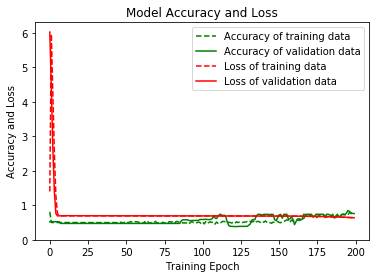

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0

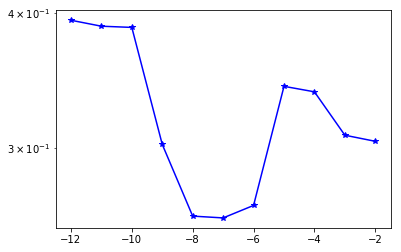

save txt have done


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:147: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


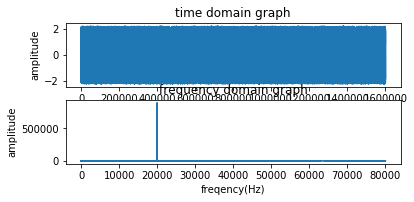

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [-0.36348692 -0.00733406 -2.01697155 ...  0.9939019   0.98320583
  0.9594857 ]
im_noise [0. 0. 0. ... 0. 0. 0.]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 524us/step - loss: 0.6421 - acc: 0.6712 - val_loss: 0.6289 - val_acc: 0.7700
Epoch 2/200
800/800 [==============================] - 0s 536us/step - loss: 0.6257 - acc: 0.7775 - val_loss: 0.6230 - val_acc: 0.8200
Epoch 3/200
800/800 [==============================] - 0s 514us/step - loss: 0.6243 - acc: 0.7612 - val_loss: 0.6157 - val_acc: 0.8800
Epoch 4/200
800/800 [==============================] - 0s 534us/step - loss: 0.6106 - acc: 0.8363 - val_loss: 0.6053 - val_acc: 0.8800
Epoch 5/200
800/800 [==============================] - 0s 546us/step - loss: 0.6065 - acc: 0.8250 - val_loss: 0.6047 - val_acc: 0.8800
Epoch 6/200


800/800 [==============================] - 0s 514us/step - loss: 0.2882 - acc: 0.9775 - val_loss: 0.2586 - val_acc: 1.0000
Epoch 60/200
800/800 [==============================] - 0s 530us/step - loss: 0.2724 - acc: 0.9850 - val_loss: 0.2547 - val_acc: 1.0000
Epoch 61/200
800/800 [==============================] - 0s 521us/step - loss: 0.2709 - acc: 0.9850 - val_loss: 0.2463 - val_acc: 1.0000
Epoch 62/200
800/800 [==============================] - 0s 583us/step - loss: 0.2645 - acc: 0.9738 - val_loss: 0.2413 - val_acc: 1.0000
Epoch 63/200
800/800 [==============================] - 0s 523us/step - loss: 0.2652 - acc: 0.9788 - val_loss: 0.2378 - val_acc: 1.0000
Epoch 64/200
800/800 [==============================] - 0s 536us/step - loss: 0.2560 - acc: 0.9850 - val_loss: 0.2367 - val_acc: 1.0000
Epoch 65/200
800/800 [==============================] - 0s 512us/step - loss: 0.2591 - acc: 0.9863 - val_loss: 0.2254 - val_acc: 1.0000
Epoch 66/200
800/800 [==============================] - 0s 53

Epoch 179/200
800/800 [==============================] - 0s 524us/step - loss: 0.0484 - acc: 0.9950 - val_loss: 0.0351 - val_acc: 1.0000
Epoch 180/200
800/800 [==============================] - 0s 504us/step - loss: 0.0448 - acc: 0.9988 - val_loss: 0.0350 - val_acc: 1.0000
Epoch 181/200
800/800 [==============================] - 0s 533us/step - loss: 0.0528 - acc: 0.9975 - val_loss: 0.0344 - val_acc: 1.0000
Epoch 182/200
800/800 [==============================] - 0s 528us/step - loss: 0.0478 - acc: 0.9975 - val_loss: 0.0342 - val_acc: 1.0000
Epoch 183/200
800/800 [==============================] - 0s 519us/step - loss: 0.0482 - acc: 0.9938 - val_loss: 0.0342 - val_acc: 1.0000
Epoch 184/200
800/800 [==============================] - 0s 546us/step - loss: 0.0474 - acc: 0.9975 - val_loss: 0.0341 - val_acc: 1.0000
Epoch 185/200
800/800 [==============================] - 0s 511us/step - loss: 0.0468 - acc: 0.9975 - val_loss: 0.0336 - val_acc: 1.0000
Epoch 186/200
800/800 [==================

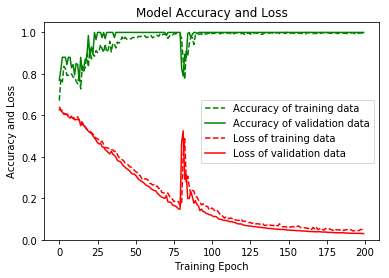

data_0 [0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1

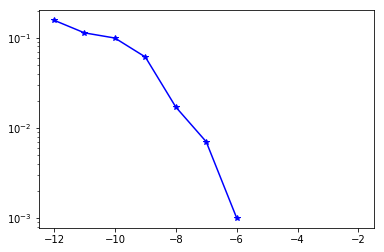

save txt have done


In [11]:
from pylab import *
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -6 # -6 #-4 #0 #6   #15
fs = fc*sample_num


cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr_6dB_comb0.h5')

#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)

model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-6dBv20_te_12_2_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

##################################******************************************************
####################--------ebn0=-4----------------------------------##############
from pylab import *
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -4 # -6 #-4 #0 #6   #15
fs = fc*sample_num


cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr_4dB_comb0.h5')

#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)

model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-4dBv20_te_12_2_comb.txt',BER,fmt='%0.8f')
print('save txt have done')


# yita=0 train -5 -7 dB -7dB就已经不行了，BER=0.5左右了，-8不用测了

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


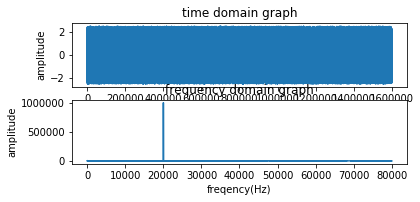

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [ 0.44881877 -0.51482748 -1.18678152 ...  0.41155046  1.95178306
  0.95663044]
im_noise [0. 0. 0. ... 0. 0. 0.]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 537us/step - loss: 0.0623 - acc: 0.9962 - val_loss: 0.0387 - val_acc: 1.0000
Epoch 2/200
800/800 [==============================] - 0s 551us/step - loss: 0.0607 - acc: 0.9988 - val_loss: 0.0366 - val_acc: 1.0000
Epoch 3/200
800/800 [==============================] - 0s 551us/step - loss: 0.0613 - acc: 0.9988 - val_loss: 0.0394 - val_acc: 1.0000
Epoch 4/200
800/800 [==============================] - 0s 537us/step - loss: 0.0558 - acc: 0.9963 - val_loss: 0.0373 - val_acc: 1.0000
Epoch 5/200
800/800 [==============================] - 0s 538us/step - loss: 0.0533 - acc: 0.9975 - val_loss: 0.0358 - val_acc: 1.0000
Epoch 6/200


800/800 [==============================] - 0s 546us/step - loss: 0.0366 - acc: 0.9962 - val_loss: 0.0222 - val_acc: 1.0000
Epoch 60/200
800/800 [==============================] - 0s 515us/step - loss: 0.0369 - acc: 0.9962 - val_loss: 0.0225 - val_acc: 1.0000
Epoch 61/200
800/800 [==============================] - 0s 540us/step - loss: 0.0415 - acc: 0.9938 - val_loss: 0.0224 - val_acc: 1.0000
Epoch 62/200
800/800 [==============================] - 0s 545us/step - loss: 0.0347 - acc: 0.9975 - val_loss: 0.0222 - val_acc: 1.0000
Epoch 63/200
800/800 [==============================] - 0s 552us/step - loss: 0.0400 - acc: 0.9938 - val_loss: 0.0221 - val_acc: 1.0000
Epoch 64/200
800/800 [==============================] - 0s 503us/step - loss: 0.0369 - acc: 0.9950 - val_loss: 0.0240 - val_acc: 1.0000
Epoch 65/200
800/800 [==============================] - 0s 526us/step - loss: 0.0379 - acc: 0.9950 - val_loss: 0.0219 - val_acc: 1.0000
Epoch 66/200
800/800 [==============================] - 0s 54

Epoch 179/200
800/800 [==============================] - 0s 522us/step - loss: 0.0247 - acc: 0.9975 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 180/200
800/800 [==============================] - 0s 532us/step - loss: 0.0192 - acc: 1.0000 - val_loss: 0.0151 - val_acc: 1.0000
Epoch 181/200
800/800 [==============================] - 0s 534us/step - loss: 0.0238 - acc: 0.9963 - val_loss: 0.0140 - val_acc: 1.0000
Epoch 182/200
800/800 [==============================] - 0s 514us/step - loss: 0.0234 - acc: 0.9988 - val_loss: 0.0139 - val_acc: 1.0000
Epoch 183/200
800/800 [==============================] - 0s 521us/step - loss: 0.0238 - acc: 0.9988 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 184/200
800/800 [==============================] - 0s 531us/step - loss: 0.0268 - acc: 0.9950 - val_loss: 0.0142 - val_acc: 1.0000
Epoch 185/200
800/800 [==============================] - 0s 538us/step - loss: 0.0250 - acc: 0.9950 - val_loss: 0.0141 - val_acc: 1.0000
Epoch 186/200
800/800 [==================

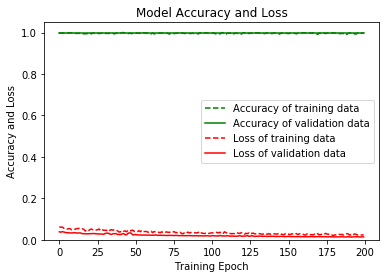

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0.
 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1.
 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0

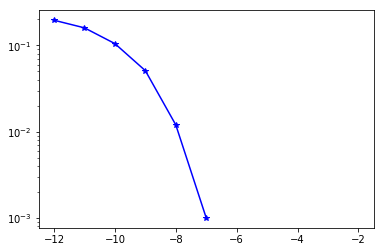

save txt have done


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


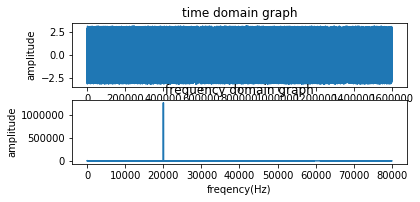

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [ 0.13175123 -0.66613089 -1.09603932 ...  1.13258388  1.24775599
  0.98534487]
im_noise [0. 0. 0. ... 0. 0. 0.]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 525us/step - loss: 0.0697 - acc: 0.9925 - val_loss: 0.0562 - val_acc: 0.9950
Epoch 2/200
800/800 [==============================] - 0s 539us/step - loss: 0.1843 - acc: 0.9325 - val_loss: 2.5838 - val_acc: 0.5850
Epoch 3/200
800/800 [==============================] - 0s 533us/step - loss: 3.1914 - acc: 0.5075 - val_loss: 2.7248 - val_acc: 0.5850
Epoch 4/200
800/800 [==============================] - 0s 536us/step - loss: 3.2876 - acc: 0.5075 - val_loss: 2.6894 - val_acc: 0.5850
Epoch 5/200
800/800 [==============================] - 0s 534us/step - loss: 3.2713 - acc: 0.5062 - val_loss: 2.6426 - val_acc: 0.5850
Epoch 6/200


800/800 [==============================] - 0s 566us/step - loss: 0.7983 - acc: 0.5025 - val_loss: 0.6931 - val_acc: 0.5850
Epoch 60/200
800/800 [==============================] - 0s 597us/step - loss: 0.7618 - acc: 0.5187 - val_loss: 0.7001 - val_acc: 0.4150
Epoch 61/200
800/800 [==============================] - 0s 567us/step - loss: 0.7925 - acc: 0.5100 - val_loss: 0.7128 - val_acc: 0.4150
Epoch 62/200
800/800 [==============================] - 0s 554us/step - loss: 0.7793 - acc: 0.4925 - val_loss: 0.7185 - val_acc: 0.4150
Epoch 63/200
800/800 [==============================] - 0s 566us/step - loss: 0.7732 - acc: 0.5188 - val_loss: 0.7073 - val_acc: 0.4150
Epoch 64/200
800/800 [==============================] - 0s 534us/step - loss: 0.7851 - acc: 0.4963 - val_loss: 0.7053 - val_acc: 0.4150
Epoch 65/200
800/800 [==============================] - 0s 518us/step - loss: 0.7829 - acc: 0.4812 - val_loss: 0.7127 - val_acc: 0.4150
Epoch 66/200
800/800 [==============================] - 0s 51

Epoch 179/200
800/800 [==============================] - 0s 544us/step - loss: 0.6979 - acc: 0.5050 - val_loss: 0.6969 - val_acc: 0.4150
Epoch 180/200
800/800 [==============================] - 0s 538us/step - loss: 0.6950 - acc: 0.5225 - val_loss: 0.6958 - val_acc: 0.4150
Epoch 181/200
800/800 [==============================] - 0s 522us/step - loss: 0.6961 - acc: 0.5187 - val_loss: 0.6946 - val_acc: 0.4150
Epoch 182/200
800/800 [==============================] - 0s 518us/step - loss: 0.6986 - acc: 0.4863 - val_loss: 0.6951 - val_acc: 0.4150
Epoch 183/200
800/800 [==============================] - 0s 533us/step - loss: 0.7029 - acc: 0.4850 - val_loss: 0.6979 - val_acc: 0.4150
Epoch 184/200
800/800 [==============================] - 0s 540us/step - loss: 0.6981 - acc: 0.4812 - val_loss: 0.6978 - val_acc: 0.4150
Epoch 185/200
800/800 [==============================] - 0s 569us/step - loss: 0.7014 - acc: 0.5000 - val_loss: 0.6946 - val_acc: 0.4150
Epoch 186/200
800/800 [==================

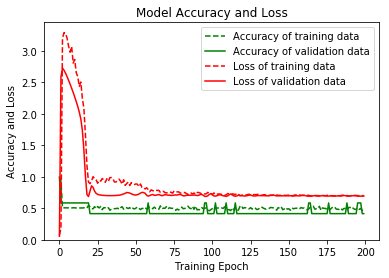

data_0 [1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1.
 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1.
 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0.
 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1.
 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0

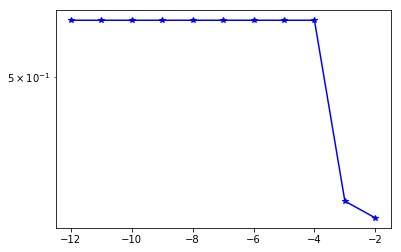

save txt have done


In [12]:
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -5 # -6 #-4 #0 #6   #15
fs = fc*sample_num


cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr_5dB_comb0.h5')

#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)

model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-5dBv20_te_12_2_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

##################################******************************************************
####################--------ebn0=-7----------------------------------##############
from pylab import *
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -7 # -6 #-4 #0 #6   #15
fs = fc*sample_num


cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr_7dB_comb0.h5')

#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)

model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-7dBv20_te_12_2_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

# yita = 0 train -3 -1dB

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  if __name__ == '__main__':


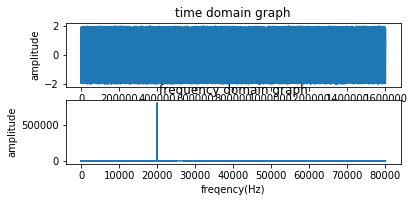

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [-0.23887268 -1.1612783  -1.02999447 ...  0.0589876   0.68797766
  0.58965189]
im_noise [0. 0. 0. ... 0. 0. 0.]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 533us/step - loss: 0.6521 - acc: 0.5325 - val_loss: 0.6488 - val_acc: 0.6050
Epoch 2/200
800/800 [==============================] - 0s 528us/step - loss: 0.6478 - acc: 0.5725 - val_loss: 0.6236 - val_acc: 0.6400
Epoch 3/200
800/800 [==============================] - 0s 544us/step - loss: 0.6289 - acc: 0.6075 - val_loss: 0.6014 - val_acc: 0.6750
Epoch 4/200
800/800 [==============================] - 0s 544us/step - loss: 0.6216 - acc: 0.6337 - val_loss: 0.5717 - val_acc: 0.4900
Epoch 5/200
800/800 [==============================] - 0s 530us/step - loss: 0.5877 - acc: 0.6425 - val_loss: 0.5737 - val_acc: 0.7200
Epoch 6/200


800/800 [==============================] - 0s 555us/step - loss: 0.0825 - acc: 0.9988 - val_loss: 0.0523 - val_acc: 1.0000
Epoch 60/200
800/800 [==============================] - 0s 550us/step - loss: 0.0749 - acc: 1.0000 - val_loss: 0.0414 - val_acc: 1.0000
Epoch 61/200
800/800 [==============================] - 0s 527us/step - loss: 0.0638 - acc: 1.0000 - val_loss: 0.0392 - val_acc: 1.0000
Epoch 62/200
800/800 [==============================] - 0s 526us/step - loss: 0.0582 - acc: 0.9975 - val_loss: 0.1331 - val_acc: 0.9250
Epoch 63/200
800/800 [==============================] - 0s 546us/step - loss: 0.1857 - acc: 0.8763 - val_loss: 0.0857 - val_acc: 0.9800
Epoch 64/200
800/800 [==============================] - 0s 523us/step - loss: 0.1396 - acc: 0.9350 - val_loss: 0.0988 - val_acc: 0.9950
Epoch 65/200
800/800 [==============================] - 0s 547us/step - loss: 0.0921 - acc: 1.0000 - val_loss: 0.0618 - val_acc: 1.0000
Epoch 66/200
800/800 [==============================] - 0s 54

Epoch 177/200
800/800 [==============================] - 0s 516us/step - loss: 5.6743e-04 - acc: 1.0000 - val_loss: 3.7608e-04 - val_acc: 1.0000
Epoch 178/200
800/800 [==============================] - 0s 540us/step - loss: 5.8209e-04 - acc: 1.0000 - val_loss: 3.7474e-04 - val_acc: 1.0000
Epoch 179/200
800/800 [==============================] - 0s 532us/step - loss: 6.2159e-04 - acc: 1.0000 - val_loss: 3.6335e-04 - val_acc: 1.0000
Epoch 180/200
800/800 [==============================] - 0s 527us/step - loss: 6.8193e-04 - acc: 1.0000 - val_loss: 3.4816e-04 - val_acc: 1.0000
Epoch 181/200
800/800 [==============================] - 0s 538us/step - loss: 6.5471e-04 - acc: 1.0000 - val_loss: 3.3566e-04 - val_acc: 1.0000
Epoch 182/200
800/800 [==============================] - 0s 545us/step - loss: 5.5570e-04 - acc: 1.0000 - val_loss: 3.2839e-04 - val_acc: 1.0000
Epoch 183/200
800/800 [==============================] - 0s 560us/step - loss: 5.1610e-04 - acc: 1.0000 - val_loss: 3.2518e-04 - v

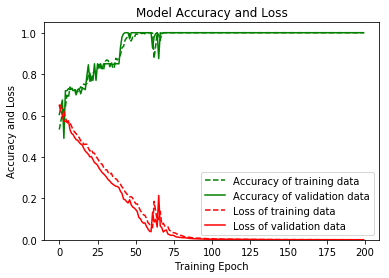

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:85: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:89: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


data_0 [1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1.
 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0.
 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1.
 0. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 0.
 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1

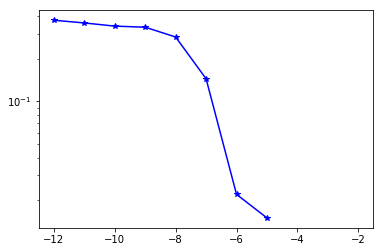

save txt have done


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


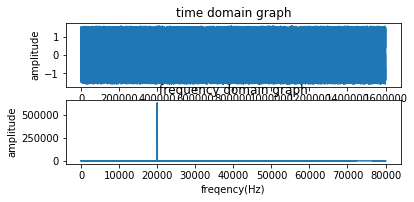

the noise has been prepared
the shape of impulsive noise (1600000,)
cmb [ 0.00228699 -0.07594539 -0.79678789 ...  0.65038958  1.12361574
  0.01939107]
im_noise [0. 0. 0. ... 0. 0. 0.]
signals has been prepared
shape of X_train (1000, 1600) shape of y_train (1000, 2)
Train on 800 samples, validate on 200 samples
Epoch 1/200
800/800 [==============================] - 0s 529us/step - loss: 7.3439e-04 - acc: 1.0000 - val_loss: 3.8233e-04 - val_acc: 1.0000
Epoch 2/200
800/800 [==============================] - 0s 544us/step - loss: 7.0835e-04 - acc: 1.0000 - val_loss: 3.6978e-04 - val_acc: 1.0000
Epoch 3/200
800/800 [==============================] - 0s 539us/step - loss: 7.1465e-04 - acc: 1.0000 - val_loss: 3.6721e-04 - val_acc: 1.0000
Epoch 4/200
800/800 [==============================] - 0s 523us/step - loss: 6.3325e-04 - acc: 1.0000 - val_loss: 3.6111e-04 - val_acc: 1.0000
Epoch 5/200
800/800 [==============================] - 0s 549us/step - loss: 6.1142e-04 - acc: 1.0000 - val_loss: 3

Epoch 56/200
800/800 [==============================] - 0s 539us/step - loss: 2.0560e-04 - acc: 1.0000 - val_loss: 1.4086e-04 - val_acc: 1.0000
Epoch 57/200
800/800 [==============================] - 0s 539us/step - loss: 2.1966e-04 - acc: 1.0000 - val_loss: 1.4029e-04 - val_acc: 1.0000
Epoch 58/200
800/800 [==============================] - 0s 520us/step - loss: 2.1557e-04 - acc: 1.0000 - val_loss: 1.3906e-04 - val_acc: 1.0000
Epoch 59/200
800/800 [==============================] - 0s 541us/step - loss: 2.3362e-04 - acc: 1.0000 - val_loss: 1.3818e-04 - val_acc: 1.0000
Epoch 60/200
800/800 [==============================] - 0s 518us/step - loss: 2.2059e-04 - acc: 1.0000 - val_loss: 1.3564e-04 - val_acc: 1.0000
Epoch 61/200
800/800 [==============================] - 0s 530us/step - loss: 1.9263e-04 - acc: 1.0000 - val_loss: 1.3282e-04 - val_acc: 1.0000
Epoch 62/200
800/800 [==============================] - 0s 554us/step - loss: 1.6777e-04 - acc: 1.0000 - val_loss: 1.3093e-04 - val_acc:

Epoch 113/200
800/800 [==============================] - 0s 540us/step - loss: 1.3857e-04 - acc: 1.0000 - val_loss: 9.6509e-05 - val_acc: 1.0000
Epoch 114/200
800/800 [==============================] - 0s 573us/step - loss: 1.3142e-04 - acc: 1.0000 - val_loss: 9.6134e-05 - val_acc: 1.0000
Epoch 115/200
800/800 [==============================] - 0s 520us/step - loss: 1.6993e-04 - acc: 1.0000 - val_loss: 9.5795e-05 - val_acc: 1.0000
Epoch 116/200
800/800 [==============================] - 0s 553us/step - loss: 1.2506e-04 - acc: 1.0000 - val_loss: 9.5149e-05 - val_acc: 1.0000
Epoch 117/200
800/800 [==============================] - 0s 527us/step - loss: 1.2799e-04 - acc: 1.0000 - val_loss: 9.4701e-05 - val_acc: 1.0000
Epoch 118/200
800/800 [==============================] - 0s 533us/step - loss: 1.6000e-04 - acc: 1.0000 - val_loss: 9.4633e-05 - val_acc: 1.0000
Epoch 119/200
800/800 [==============================] - 0s 547us/step - loss: 1.0551e-04 - acc: 1.0000 - val_loss: 9.4367e-05 - v

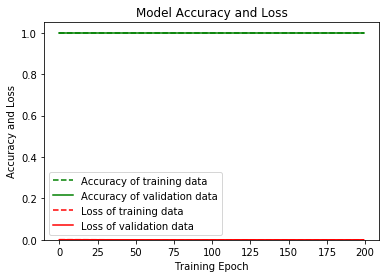

data_0 [0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1.
 0. 0. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1.
 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1.
 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0.
 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.
 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1

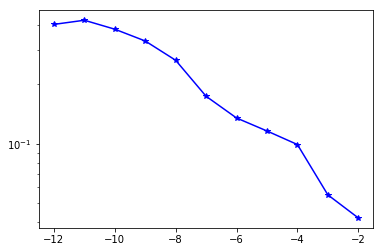

save txt have done


In [13]:
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -3 # -6 #-4 #0 #6   #15
fs = fc*sample_num


cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr_3dB_comb0.h5')

#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)

model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-3dBv20_te_12_2_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

##################################******************************************************
####################--------ebn0=-1----------------------------------##############
from pylab import *
#------------prepare combine noise-------------------
yita = 0  #yita = imnoise/combine noise
EbN0 = -1 # -6 #-4 #0 #6   #15
fs = fc*sample_num


cmb_noise = combnoise2(EbN0,len(signal_mod),fc,fs)
fft = np.fft.fft(cmb_noise)  #调用fft变换算法计算频域波形
fftx = np.linspace(0,fs/2,len(signal_mod)/2)  #频域波形x轴坐标311
subplot(312)
plot(cmb_noise)
xlabel('time(s)')
ylabel('amplitude')
title('time domain graph')

subplot(313)
plot(fftx,abs(fft[0:800000]))
xlabel('freqency(Hz)')
ylabel('amplitude')
title('frequency domain graph')

show()
im_noise=cmbn.imnoise(EbN0,yita,signal_mod.shape,alpha=1.5)  #alpha=1.2
signal_mod0 = signal_mod+im_noise+cmb_noise
#X_train = signal_mod0.reshape(data_len,sample_num,200)
print('the noise has been prepared')
print('the shape of impulsive noise',im_noise.shape)
#------prpare the data-+---------------
X_train=np.zeros((data_len,1600))
X_test=np.zeros((data_len,1600))
X_train = signal_mod0.reshape(data_len,1600) 

data_0=(data+1)/2

#X_train_pre=signal_mod
y_train = np_utils.to_categorical(data_0, num_classes=2)
print('cmb',cmb_noise)
print('im_noise',im_noise)
y_test=y_train
#X_train = X_train_pre.reshape(data_len,sample_num*multi)
X_test=X_train

print ('signals has been prepared')
print('shape of X_train',X_train.shape,'shape of y_train',y_train.shape)
#-------------load the model-------------
from keras.models import load_model 
#model_m = load_model ('GCNN_tr-2dBv7_alpha15.h5')
##-----------the training parameters---------------
# Hyper-parameters
BATCH_SIZE = 500
EPOCHS = 200
#for i in range(2):
#    X_train[0:data_len,0:sample_num,i]= X_train[0:data_len,0:sample_num,i] +im_noise[0,0:data_len,0:sample_num]
    #X_test[0:data_len,0:sample_num,i]= X_test[0:data_len,0:sample_num,i] +im_noise[7,0:data_len,0:sample_num]
#X_test=X_test+im_noise
# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                    #  callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)
                     

# %%
#score = model_m.evaluate(X_test, y_test, verbose=1)
#print("\nAccuracy on test data: %0.2f" % score[1])
#print("\nLoss on test data: %0.2f" % score[0])
print("\n--- Learning curve of model training ---\n")
# summarize history for accuracy and loss
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
plt.plot(history.history['loss'], "r--", label="Loss of training data")
plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
#np.savetxt('loss_MSK_GCNN_tr-2dB_alpha12.txt',history.history['loss'],fmt='%0.8f')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()
model_m.save('GCNN_tr_1dB_comb0.h5')

#------test data generating---------------
data,data_p=symbol_out(data_len)
I_out,Q_out=IQ_msk(data,data_len,sample_num,Rb)
signal_mod=carriermod(fc,Rb,I_out,Q_out)
#--generate noise--------------


#X_train = signal_mod0.reshape(data_len,sample_num,200)

#signal_mod0 = signal_mod + im_noise

data_0=(data+1)/2
print('data_0',data_0)
Y_test = np_utils.to_categorical(data_0, num_classes=2)
print('Y_test',Y_test)

model2 = model_m
#-----test and plot----------
#---plot ber curve-------------
yita=0
EbN0 =[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # ##[-5,-4,-3,-2,-1,0,1,2,3] #[-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2] # #[-8,-7,-6,-5,-4,-3,-2,-1,0]  #[1,2,3,4,5] # 
BER = [0]*len(EbN0)
loop_num = [1]*len(EbN0)    #[1,1,10,10,10,10,100,100,1000]
for i in range(len(EbN0)):
  #EbN0[i] = GSNR[i]/2
  cmb_noise = combnoise2(EbN0[i],len(signal_mod),fc,fs)
  #print(cmb_noise)


  im_noise=cmbn.imnoise(EbN0[i],yita,signal_mod.shape,alpha=1.5)
  signal_mod0 = signal_mod+im_noise+cmb_noise
  X_test = signal_mod0.reshape(data_len,1600) 
  BER_loop = [0]*loop_num[i]
  wrong = [0]*loop_num[i]
  wrong_sum = 0
  for loop in range(loop_num[i]):
    
    loss,accuracy = model2.evaluate(X_test, Y_test)
    BER_loop[loop] = 1- accuracy
    wrong[loop] = BER_loop[loop]*data_len
  wrong_sum = sum(wrong)
  BER[i] = wrong_sum/(data_len*loop_num[i])
  print('BER',BER[i])
plt.semilogy(EbN0,BER,'b*-')
plt.savefig('BER_MSK_GCNN_tr2dBv8_te_5_2dB_alpha12.jpg')
plt.show()
np.savetxt('BER_MSK_GCNN_tr-1dBv20_te_12_2_comb.txt',BER,fmt='%0.8f')
print('save txt have done')

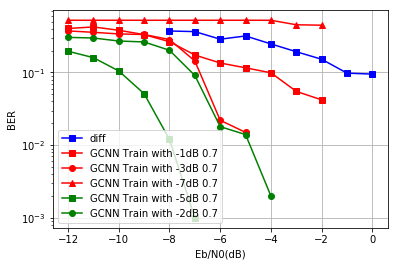

In [5]:
#-------------------plot the combine BER---------------
import matplotlib.pyplot as plt
import numpy as np 
EbN0 = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2]
BERt_1 = np.loadtxt('BER_MSK_GCNN_tr-1dBv20_te_12_2_comb.txt')
BERt_3 = np.loadtxt('BER_MSK_GCNN_tr-3dBv20_te_12_2_comb.txt')
BERt_7 = np.loadtxt('BER_MSK_GCNN_tr-7dBv20_te_12_2_comb.txt')
BERt_5 = np.loadtxt('BER_MSK_GCNN_tr-5dBv20_te_12_2_comb.txt')
BERt_2 = np.loadtxt('BER_MSK_GCNN_tr-2dBv20_te_12_2_comb.txt')


#BERv = np.loadtxt('BER_a15_ebn0_5_3.txt')
ebn0c = [-3,-2,-1,0,1,2,3]
#BERc = [0.18,0.12,0.08,0.045,0.025,0.012,0.0045]
ebn02 = [-5,-4,-3,-2,-1,0,1,2,3]
#plt.semilogy(ebn0c,BERc,'bs-',label = 'paper')
#plt.semilogy(EbN0,BERv,'b^-',label = 'viterbi')

BERdf = [3.7200000e-01,3.6500000e-01,2.8700000e-01,3.1800000e-01,2.4700000e-01,1.9300000e-01,1.5200000e-01,9.8000000e-02,9.5000000e-02]
ebn0df = [-8,-7,-6,-5,-4,-3,-2,-1,0]
BERv = [4.0492000e-01,3.8396000e-01,3.5986000e-01,3.2798000e-01,3.0494000e-01,2.7338000e-01,2.3950000e-01,2.0614000e-01,1.7750000e-01]
#plt.semilogy(ebn02,BERv,'b^-',label = 'viterbi')
plt.semilogy(ebn0df,BERdf,'bs-',label = 'diff')
plt.semilogy(EbN0,BERt_1,'rs-',label = 'GCNN Train with -1dB 0.7')
plt.semilogy(EbN0,BERt_3,'ro-',label = 'GCNN Train with -3dB 0.7')
plt.semilogy(EbN0,BERt_7,'r^-',label = 'GCNN Train with -7dB 0.7')
plt.semilogy(EbN0,BERt_5,'gs-',label = 'GCNN Train with -5dB 0.7')
plt.semilogy(EbN0,BERt_2,'go-',label = 'GCNN Train with -2dB 0.7')


plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')
plt.legend(loc=0)
#plt.axis([-6,2.1,0.1,0.5])
plt.grid(True)
plt.show()

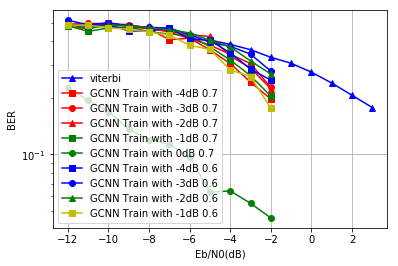

In [14]:
#-------------------plot the combine BER---------------
import matplotlib.pyplot as plt
import numpy as np 
#EbN0 = [-5,-4,-3,-2,-1,0,1,2,3]
BERt7_4 = np.loadtxt('BER_MSK_GCNN_tr-4dB_te_12_4_comb07.txt')
BERt7_3 = np.loadtxt('BER_MSK_GCNN_tr-3dB_te_12_4_comb07.txt')
BERt7_2 = np.loadtxt('BER_MSK_GCNN_tr-2dB_te_12_4_comb07.txt')
BERt7_1 = np.loadtxt('BER_MSK_GCNN_tr-10dBv8_te_12_4_comb07.txt')
BERt70 = np.loadtxt('BER_MSK_GCNN_tr0dB_te_12_4_comb07.txt')
BERt6_4 = np.loadtxt('BER_MSK_GCNN_tr-4dB_te_12_4_comb06.txt')
BERt6_3 = np.loadtxt('BER_MSK_GCNN_tr-3dB_te_12_4_comb06.txt')
BERt6_2 = np.loadtxt('BER_MSK_GCNN_tr-2dB_te_12_4_comb06.txt')
BERt6_1 = np.loadtxt('BER_MSK_GCNN_tr-10dBv8_te_12_4_comb06.txt')
BERt60 = np.loadtxt('BER_MSK_GCNN_tr0dB_te_12_4_comb06.txt')


#BERv = np.loadtxt('BER_a15_ebn0_5_3.txt')
ebn0c = [-3,-2,-1,0,1,2,3]
#BERc = [0.18,0.12,0.08,0.045,0.025,0.012,0.0045]
ebn02 = [-5,-4,-3,-2,-1,0,1,2,3]
#plt.semilogy(ebn0c,BERc,'bs-',label = 'paper')
#plt.semilogy(EbN0,BERv,'b^-',label = 'viterbi')
BERv = [4.0492000e-01,3.8396000e-01,3.5986000e-01,3.2798000e-01,3.0494000e-01,2.7338000e-01,2.3950000e-01,2.0614000e-01,1.7750000e-01]
plt.semilogy(ebn02,BERv,'b^-',label = 'viterbi')
plt.semilogy(EbN0,BERt7_4,'rs-',label = 'GCNN Train with -4dB 0.7')
plt.semilogy(EbN0,BERt7_3,'ro-',label = 'GCNN Train with -3dB 0.7')
plt.semilogy(EbN0,BERt7_2,'r^-',label = 'GCNN Train with -2dB 0.7')
plt.semilogy(EbN0,BERt7_1,'gs-',label = 'GCNN Train with -1dB 0.7')
plt.semilogy(EbN0,BERt70,'go-',label = 'GCNN Train with 0dB 0.7')
plt.semilogy(EbN0,BERt6_4,'bs-',label = 'GCNN Train with -4dB 0.6')
plt.semilogy(EbN0,BERt6_3,'bo-',label = 'GCNN Train with -3dB 0.6')
plt.semilogy(EbN0,BERt6_2,'g^-',label = 'GCNN Train with -2dB 0.6')
plt.semilogy(EbN0,BERt6_1,'ys-',label = 'GCNN Train with -1dB 0.6')


plt.xlabel('Eb/N0(dB)')
plt.ylabel('BER')
plt.legend(loc=0)
#plt.axis([-6,2.1,0.1,0.5])
plt.grid(True)
plt.show()